In [3]:
# Convert keras model to onnx
# You may need to reinstall protobuf (and make sure its compatible with your onnx version) https://github.com/onnx/tensorflow-onnx/issues/1557
import tensorflow as tf
import tf2onnx
import cv2
import numpy as np

model = tf.keras.models.load_model("detection_model-ex-002--loss-0008.903.h5")
print(model.outputs)

spec = (tf.TensorSpec((None, 416, 416, 3), tf.float32, name="input"),)
print(spec)
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path="test.onnx") 

[<KerasTensor: shape=(None, None, None, 33) dtype=float32 (created by layer 'last1')>, <KerasTensor: shape=(None, None, None, 33) dtype=float32 (created by layer 'last2')>, <KerasTensor: shape=(None, None, None, 33) dtype=float32 (created by layer 'last3')>]
1.10.1
(TensorSpec(shape=(None, 416, 416, 3), dtype=tf.float32, name='bottle_input'),)


(416, 416, 3)


TypeError: Invalid shape (1, 13, 13, 33) for image data

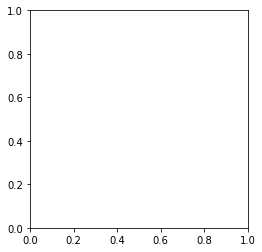

In [5]:
# Use onnx model for inference
import cv2
import matplotlib.pyplot as plt
import onnxruntime as ort
import numpy as np

IMG_SIZE = 416 # Our dataset image size
img_array = cv2.imread("bottle.jpg")
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
new_array = new_array.astype('float32')
print(new_array.shape)


ort_sess = ort.InferenceSession('test.onnx')
outputs = ort_sess.run(None, {'input': [new_array]})

# print(outputs[2].shape)

plt.imshow(outputs[0])